CIFAR10 dataset trained on all classes with resnet56 without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Jupyter-specific
%matplotlib inline

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL = 'resnet56' 
DS_INFO = 'complete'
NUM_EPOCHS = 50
BATCH_SIZE = 64

IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# Resnet56-specific variables
NUM_GPUS = 1
BS_PER_GPU = 128
BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 30), (0.01, 45)]

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

Some parameters

In [3]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/')
outcast = 'None'

DATASET_SIZE = len(list(data_dir.glob('*/*/*.*g')))
STEPS_PER_EPOCH = np.ceil(DATASET_SIZE/BATCH_SIZE)

directories = np.array([item.name for item in data_dir.glob('train/*') if item.name != 'metadata.json'])

class_names = directories
NUM_CLASSES = len(directories)
print ("Class names: ", class_names)

Class names:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']


In [4]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [5]:
samples_per_class = []
for class_name in class_names:
    class_samples = len(list(data_dir.glob('*/'+class_name+'/*.*g')))
    samples_per_class.append(class_samples)
    print('{0:18}: {1:3d}'.format(class_name, class_samples))

print ('\nTotal number of images: {}, in {} classes'.format(DATASET_SIZE, NUM_CLASSES))

# If one class contains more than half of the entire sample size
if np.max(samples_per_class) > DATASET_SIZE//2:
    print ("But the dataset is mainly shit")

cat               : 6000
airplane          : 6000
deer              : 6000
automobile        : 6000
ship              : 6000
horse             : 6000
truck             : 6000
dog               : 6000
bird              : 6000
frog              : 6000

Total number of images: 60000, in 10 classes


### Loading images with `tf.data.Dataset`.

In [6]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*.*g'))

A short pure-tensorflow function that converts a file path to an `image_data, label` pair:

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get class integer from class-list
    class_ = parts[-2], class_names
    label_int = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    # cast to tensor array with dtype=uint8
    return tf.dtypes.cast(label_int, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

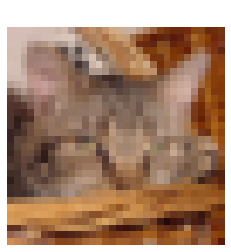

In [8]:
def show_image(img):
    if (isinstance(img, tf.data.Dataset)):
        for image, label in img:
            plt.figure(frameon=False, facecolor='white')
            title = class_names[label.numpy()]#+" ["+str(label.numpy())+"]"
            plt.title(title, fontdict={'color':'white','size':20})
            plt.imshow(image.numpy())
            plt.axis('off')
    else:
        plt.figure(frameon=False, facecolor='white')
        plt.title("None", fontdict={'color':'white','size':20})
        plt.imshow(img.numpy())
        plt.axis('off')

# Take one image
show_image(labeled_ds.take(1))

### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

Split into training, test and validation dataset

In [9]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_ds = labeled_ds.take(train_size)
test_ds = labeled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [10]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(labeled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        60000
Train dataset sample size:       42000
Test dataset sample size:         9000
Validation dataset sample size:   9000


In [11]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/{}_train.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/{}_test.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/{}_val.tfcache".format(IMG_WIDTH))

## Training

### Resnet56 (not pretrained)
See https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification

In [12]:
import resnet
import datetime
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

In [13]:
PATH = os.getenv('PATH')
%env PATH=/home/henrik/anaconda3/envs/TF2/bin:$PATH

env: PATH=/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/henrik/.dotnet/tools


In [14]:
def schedule(epoch):
    initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
    learning_rate = initial_learning_rate
    for mult, start_epoch in LR_SCHEDULE:
        if epoch >= start_epoch:
            learning_rate = initial_learning_rate * mult
        else:
            break
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

Create and compile the model

In [15]:
img_input = tf.keras.layers.Input(shape=IMG_SIZE)
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    resnet56_model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
    resnet56_model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        resnet56_model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
        resnet56_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

In [16]:
resnet56_model.summary()

Model: "resnet56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
___________________________________________________________________________________________

In [17]:
log_dir="logs/resnet56/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        update_freq='batch',
        histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)

Train the model

In [18]:
history = resnet56_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = [tensorboard_callback, lr_schedule_callback])

Train for 656 steps, validate for 140 steps
Epoch 1/50
656/656 [==============================] - 37s 56ms/step - loss: 3.3331 - sparse_categorical_accuracy: 0.1456 - val_loss: 3.8788 - val_sparse_categorical_accuracy: 0.0923
Epoch 2/50
656/656 [==============================] - 25s 38ms/step - loss: 2.4269 - sparse_categorical_accuracy: 0.3218 - val_loss: 6.5018 - val_sparse_categorical_accuracy: 0.1408
Epoch 3/50
656/656 [==============================] - 25s 38ms/step - loss: 1.8981 - sparse_categorical_accuracy: 0.4616 - val_loss: 5.6419 - val_sparse_categorical_accuracy: 0.2086
Epoch 4/50
656/656 [==============================] - 25s 38ms/step - loss: 1.5432 - sparse_categorical_accuracy: 0.5687 - val_loss: 1.6719 - val_sparse_categorical_accuracy: 0.5397
Epoch 5/50
656/656 [==============================] - 25s 38ms/step - loss: 1.2999 - sparse_categorical_accuracy: 0.6502 - val_loss: 1.8869 - val_sparse_categorical_accuracy: 0.5364
Epoch 6/50
656/656 [==========================

In [55]:
# resnet56_model.save('models/{}.h5'.format(model_name))
# resnet56_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [24]:
resnet56_evaluate = resnet56_model.evaluate(val_ds, verbose=2, steps=val_size//BATCH_SIZE)

140/140 - 2s - loss: 0.4109 - sparse_categorical_accuracy: 0.9583


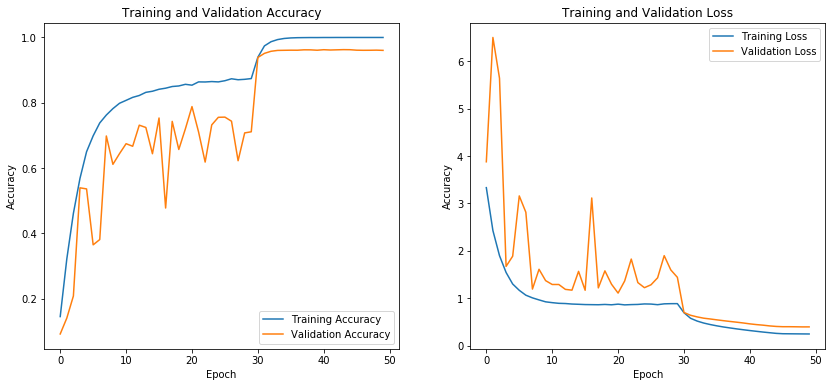

In [25]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [51]:
# Fetch one batch from validation dataset
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 cat
1.0000 airplane
0.0000 deer
0.0000 automobile
0.0000 ship
0.0000 horse
0.0000 truck
0.0000 dog
0.0000 bird
0.0000 frog

Label: airplane
Predicton: airplane


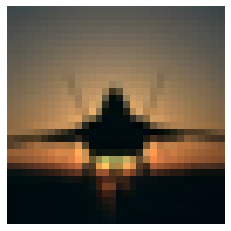

In [52]:
# Get a random image and label
rand = np.random.randint(0, BATCH_SIZE)
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet56_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,class_names[i]))

print ("\nLabel:", class_names[label])
print ("Predicton:", class_names[np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [53]:
# Predict one batch
predictions = resnet56_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = class_names[labels[i]]
    prediction = class_names[np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  cat         cat       
  1  deer        deer      
  2  bird        bird      
  3  truck       truck     
  4  airplane    airplane  
  5  deer        deer      
  6  frog        frog      
  7  automobile  automobile
  8  horse       horse     
  9  airplane    airplane  
 10  frog        frog      
 11  horse       horse     
 12  deer        deer      
 13  truck       truck     
 14  deer        deer      
 15  cat         cat       
 16  automobile  automobile
 17  automobile  automobile
 18  dog         dog       
 19  bird        deer        Wrong
 20  horse       horse     
 21  deer        deer      
 22  deer        deer      
 23  truck       truck     
 24  horse       horse     
 25  horse       deer        Wrong
 26  automobile  automobile
 27  cat         cat       
 28  ship        ship      
 29  deer        deer      
 30  automobile  automobile
 31  horse       deer        Wrong
 32  bird        bird      
 33  f